In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import os
import time
import glob
import copy
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from getImg import *
from makeLgMatrix import *
from bkgSubtraction import *
from rebinImg import *
from centering import *
from getImgNorm import *
from getImgInfo import *
from fitLegendres import *
from saveResults import *
from queryFolder import *
from onlineAnalysis import onlineAnalysis

# Specify all analysis variables
Configuration class holds all analysis parameters

In [2]:
class CONFIG():


    ###################################
    ###  file querying information  ###
    ###################################

    self.doQueryFolder  = True
    self.queryBkgAddr   = None
    self.queryFolder    = "testData"
    self.fileExtention  = ".tif"


    ########################
    ###  saving results  ###
    ########################

    self.saveQueryResults   = False
    self.saveLoadedResults  = False
    self.saveFolder         = "results"
    self.saveFileName       = "fullResults"


    ##################################
    ###  loading results and data  ###
    ##################################

    # load previous data
    self.loadFolders    = []       # do not load anything if empty
    self.fileExtention  = ".tif"
    """
    badRuns = ["096","111","1i18","010","138","149","035","039","077","007","086","008","091","026"]
    for fld in glob.glob("/reg/ued/ana/scratch/CHD/20161212/LongScan2/run*"):
      skip = False
      for i in badRuns:
        if "run"+i in fld:
          skip = True
          break
      if skip:
        continue

        print(fld)
        self.loadFolders.append({
            "folder": fld + "/images-ANDOR1", 
            "background": None,
            #"background": "/reg/ued/ana/scratch/CHD/20161212/LongScan2/run013/images-ANDOR1/ANDOR1_delayHigh-001-024.4950_0001.tif",
            "centerR" : 550,
            "centerC" : 508})
    """

    # load saved results (saved by this analysis)
    self.loadSavedResults           = False
    self.loadSavedResultsFolder     = "results"
    self.loadSavedResultsFileName   = "allCHD_"


    #############################
    ###  analysis parameters  ###
    #############################

    # hot pixels
    self.hotPixel = 7000

    # image region of interest
    self.roi = 835               # if not odd, will round up to odd number

    # readout noise subtraction range
    self.ROradLow   = 0.9        # [0.85, 0.95]
    self.ROradHigh  = 0.98       # [0.95, 0.99]
    
    # image normalization range
    self.normRadLow   = 0.65     # [0.5, 0.75]
    self.normRadHigh  = 0.95     # [0.9, 0.99]
    self.sumMin       = 5.59e8   # ignore all images with a total sum below this [5e8, 5.7e8]
    self.sumMax       = 5.72e8   # ignore all images with a total sum above this [5.5e5, 6e8]

    # center finding
    self.centerR        = 550    # use None to do center finding  
    self.centerC        = 508    # use None to do center finding  
    self.guessCenterR   = 530    # [530, 570]
    self.guessCenterC   = 500    # [480, 520]
    self.centerRadLow   = 148    # use this range to determine center
    self.centerRadHigh  = 152    # use this range to determine center

    # legendre fitting parameters
    self.Nlegendres     = 6      # will fit legendres [0, Nlegendres)
    self.NradialBins    = 50     # number of radial bins when fitting
    self.Nrebin         = 5      # rebin before fitting, must be factor of roi (faster fitting)
    self.gMatrixFolder  = "./legendreFitMatrices/"
    
    
    #################################
    ###  diffraction information  ###
    #################################

    # q normalization
    self.QperPixel = 22.6/900 
    self.Qmax = self.QperPixel*self.roi/2

    # calculate sM(s) by normalizing with atomic diffraction
    self.normByAtomic = False
    self.atomicDiffractionFile = "/reg/neh/home5/khegazy/analysis/CHD/simulation/diffractionPattern/output/references/atomicScattering_CHD.dat"
    self.atomicDiffractionDataType = np.float64


    #############################
    ###  plotting parameters  ###
    #############################

    # time range
    self.plotMinDelay = 24.4

    # q range of line outs
    self.LineOutMinQ = 2
    self.LineOutMaxQ = 4

    self.plotDirectory = "plots"     # must specify file name or "." for current directory
    self.plotPrefix    = ""
    self.plotFigSize   = (14, 7)
    self.dpi           = 80


config = CONFIG()
    

# Test center and center finding algorithm
    Use this to find optimal values of either
        centerR
        centerC
        
        or
        
        guessCenterR
        guessCenterC
        centerRadLow
        centerRadHigh

Found image center at row/column 540 / 500


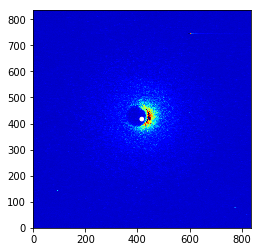

Found image center at row/column 540 / 501


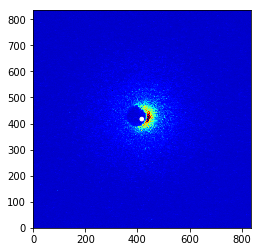

Found image center at row/column 540 / 501


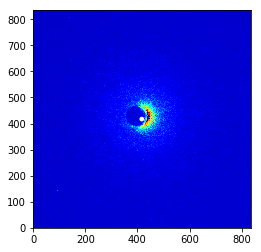

Found image center at row/column 539 / 502


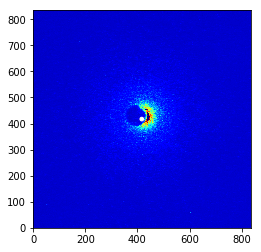

Found image center at row/column 540 / 500


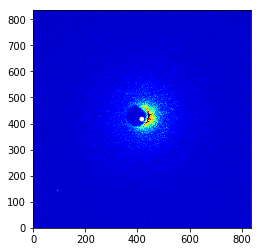

Found image center at row/column 537 / 500


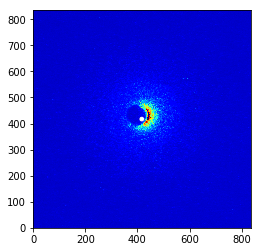

Found image center at row/column 538 / 498


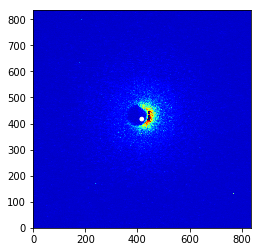

Found image center at row/column 540 / 498


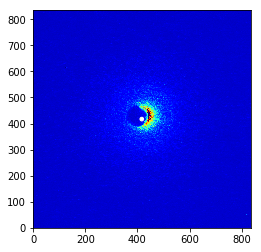

Found image center at row/column 539 / 501


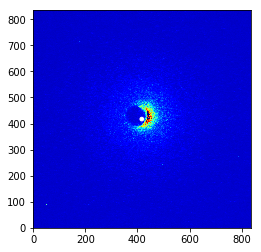

Found image center at row/column 540 / 501


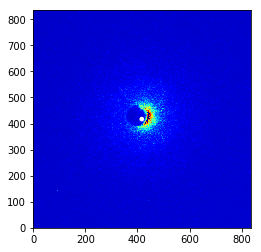

Found image center at row/column 538 / 500


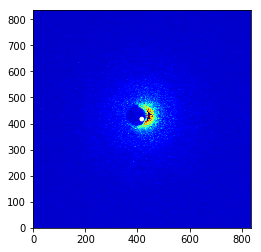

Found image center at row/column 541 / 502


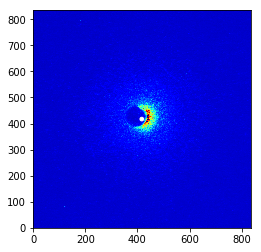

Found image center at row/column 539 / 499


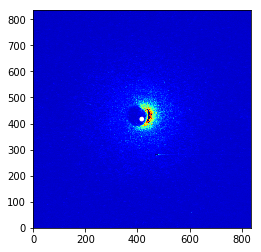

Found image center at row/column 539 / 499


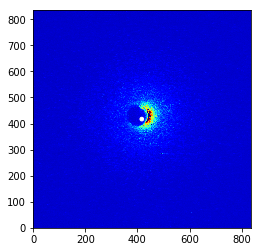

Found image center at row/column 539 / 499


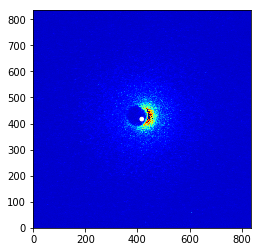

Found image center at row/column 539 / 501


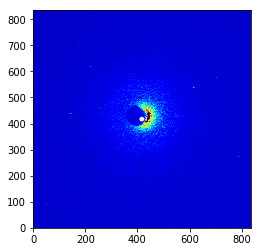

Found image center at row/column 540 / 503


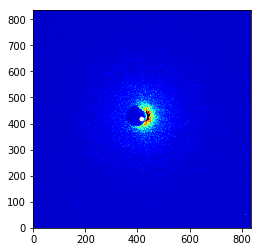

Found image center at row/column 542 / 500


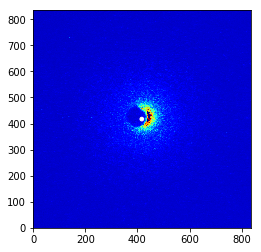

Found image center at row/column 540 / 504


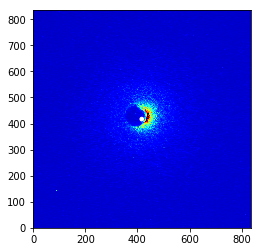

In [3]:
from matplotlib.patches import Circle

#########################################
#####  get data for center finding  #####
#########################################

testImages = []
queryFolderName = "testData"
backgroundImageAddr = None

###  get all images in query folder  ###
testImages = query_folder(queryFolderName, config.fileExtention, [])

###  get background image  ###
if backgroundImageAddr is not None:
    bkgImg = get_image(backgroundImage, config.hotPixel)

    
##########################################
#####  set center finding variables  #####
##########################################

centerConfig = copy.deepcopy(config)
centerConfig.centerR = None #550
centerConfig.centerC = None #508


#####################################
#####  plot images with center  #####
#####################################

for name in testImages:
    ###  get image and remove hot pixels  ###
    img = get_image(name, config.hotPixel)

    ###  subtract background images  ###
    if backgroundImageAddr is not None:
        img -= bkgImg 
    
    ###  center image  ###
    img, centerR, centerC = centering(img, centerConfig)
    
    print("Found image center at row/column %i / %i" % (centerR, centerC))
    
    ###  plotting results  ###
    x = np.arange(img.shape[1])
    y = np.arange(img.shape[0])
    X,Y = np.meshgrid(x, y)
    
    fig,ax = plt.subplots(1)
    ax.pcolormesh(X, Y, img, cmap="jet")
    center = Circle((config.roi/2, config.roi/2), radius=7, color='w', fill=True)
    ax.add_patch(center)
    ax.set_aspect('equal')

    plt.show()
    

    

# Plot total image sums 

Use this to specify the config variables below 
   sumMin
   sumMax

Now looking at testData/ANDOR1_delayHigh-001-024.5400_0001.tif
Now looking at testData/ANDOR1_delayHigh-002-024.5550_0001.tif
Now looking at testData/ANDOR1_delayHigh-003-024.5100_0001.tif
INFO: Rejected image testData/ANDOR1_delayHigh-003-024.5100_0001.tif with a total sum of 572792119.000000!
INFO: Total sum cut has rejected 1 images!
Now looking at testData/ANDOR1_delayHigh-004-024.6150_0001.tif
Now looking at testData/ANDOR1_delayHigh-005-024.4950_0001.tif
Now looking at testData/ANDOR1_delayHigh-006-024.3700_0001.tif
Now looking at testData/ANDOR1_delayHigh-007-024.4950_0001.tif
Now looking at testData/ANDOR1_delayHigh-007-024.5400_0001.tif
Now looking at testData/ANDOR1_delayHigh-008-024.7950_0001.tif
Now looking at testData/ANDOR1_delayHigh-009-024.5700_0001.tif
Now looking at testData/ANDOR1_delayHigh-010-024.4500_0001.tif
Now looking at testData/ANDOR1_delayHigh-011-024.4650_0001.tif
Now looking at testData/ANDOR1_delayHigh-012-024.4650_0001.tif
Now looking at testData/ANDOR1_

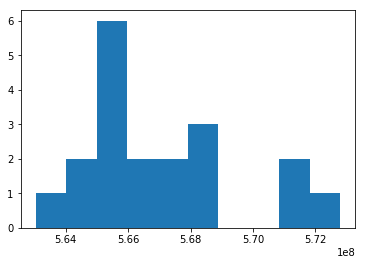

In [4]:
config.doQueryFolder = False
config.loadFolders = []

for fld in ["testData"]: #glob.glob("/reg/ued/ana/scratch/CHD/20161212/LongScan2/run*"):
    config.loadFolders.append({
        "folder": fld, 
        "background": None,
        #"background": "/reg/ued/ana/scratch/CHD/20161212/LongScan2/run013/images-ANDOR1/ANDOR1_delayHigh-001-024.4950_0001.tif",
        "centerR" : 550,
        "centerC" : 508})

imgSums = onlineAnalysis(config, getImgNormDistribution=True)

fig = plt.figure()
plt.hist(imgSums)
plt.show()

<IPython.core.display.Javascript object>


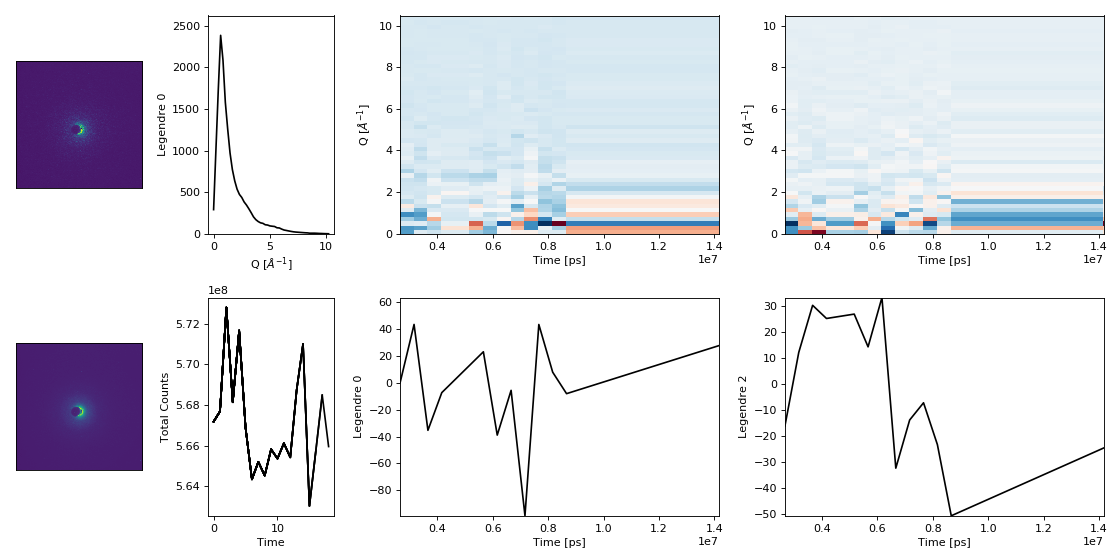

Now looking at testData/ANDOR1_delayHigh-001-024.5400_0001.tif
('delays', array([24540000]))
('plotInds', array([0]))


/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


Now looking at testData/ANDOR1_delayHigh-002-024.5550_0001.tif
('delays', array([24540000, 24555000]))
('plotInds', array([0, 1]))
Now looking at testData/ANDOR1_delayHigh-003-024.5100_0001.tif
INFO: Rejected image testData/ANDOR1_delayHigh-003-024.5100_0001.tif with a total sum of 572792119.000000!
INFO: Total sum cut has rejected 1 images!
Now looking at testData/ANDOR1_delayHigh-004-024.6150_0001.tif
('delays', array([24540000, 24555000, 24615000]))
('plotInds', array([0, 1, 2]))
Now looking at testData/ANDOR1_delayHigh-005-024.4950_0001.tif
('delays', array([24495000, 24540000, 24555000, 24615000]))
('plotInds', array([0, 1, 2, 3]))
Now looking at testData/ANDOR1_delayHigh-006-024.3700_0001.tif
('delays', array([24370000, 24495000, 24540000, 24555000, 24615000]))
('plotInds', array([1, 2, 3, 4]))
Now looking at testData/ANDOR1_delayHigh-007-024.4950_0001.tif
('delays', array([24370000, 24495000, 24540000, 24555000, 24615000]))
('plotInds', array([1, 2, 3, 4]))
Now looking at testDa

KeyboardInterrupt: 

In [5]:
%matplotlib notebook

config = CONFIG()

onlineAnalysis(config)